In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.layers import (Input, Dense, Flatten, Dropout, GlobalAveragePooling2D)
from tensorflow.keras.applications import Xception, DenseNet121, InceptionV3
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, 
    ExtraTreesClassifier, VotingClassifier, StackingClassifier
)

# Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

#for parallel threading
from joblib import parallel_backend
import cv2

#Model saving to disk
import pickle

# Suppress warnings
warnings.filterwarnings("ignore")

2025-04-28 12:48:34.253455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745844514.447786      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745844514.502937      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected: {len(gpus)}")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")
else:
    print("No GPUs detected.")

GPUs detected: 1


In [3]:
def data_frame(path):
    class_paths = []
    classes = []

    for label in os.listdir(path):
        class_dir = os.path.join(path, label)
        if os.path.isdir(class_dir):  # Ensure it's a directory
            for image in os.listdir(class_dir):
                class_paths.append(os.path.join(class_dir, image))
                classes.append(label)

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

In [4]:
dataframe = data_frame('/kaggle/input/wbc-8type-original/bloodcells_dataset Original')
from sklearn.model_selection import train_test_split
train_dataframe, temp_dataframe = train_test_split(dataframe, 
                                                   test_size=0.2, 
                                                   random_state=42, 
                                                   stratify=dataframe['Class'])
Validation_dataframe, test_dataframe = train_test_split(temp_dataframe, 
                                                        test_size=0.5, 
                                                        random_state=42, 
                                                        stratify=temp_dataframe['Class'])
print(f"Train size: {len(train_dataframe)}, Validation size: {len(Validation_dataframe)}, Test size: {len(test_dataframe)}")

Train size: 13673, Validation size: 1709, Test size: 1710


In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCH = 10
img_shape=(224,224,3)
labels = [
    "basophil",
    "eosinophil",
    "erythroblast",
    "ig",
    "lymphocyte",
    "monocyte",
    "neutrophil",
    "platelet"
]

In [6]:
def apply_clahe(img):
    """Apply CLAHE after Adaptive Gray World Normalization."""
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=0.03, tileGridSize=(8,8))
    l = clahe.apply(l)
    clahe_img = cv2.merge((l, a, b))
    return cv2.cvtColor(clahe_img, cv2.COLOR_LAB2RGB)

def preprocess_image(img):
    """First apply Adaptive Gray World, then CLAHE (No Normalization)."""
    img = img.astype(np.uint8)  # Ensure correct data type
    img = apply_clahe(img)  # Step 2: CLAHE
    img = (img - np.mean(img)) / (np.std(img) + 1e-8) # step: 3: z score normalization
    return img  

In [7]:
def preprocess_image2(image):
    # Convert to float32
    img = image.astype(np.float32)

    # Apply Z-score Normalization
    #img = (img - np.mean(img)) / (np.std(img) + 1e-8)

    # Min-Max Scaling (for CLAHE)
    img = (img - np.min(img)) / (np.ptp(img) + 1e-8)  # np.ptp = max - min
    #img = (img * 255).astype(np.uint8)  # Convert to uint8 for CLAHE

    # Apply CLAHE to each channel independently
    #clahe = cv2.createCLAHE(clipLimit=0.02, tileGridSize=(8, 8))
    #img_clahe = np.zeros_like(img)
    
    #for i in range(3):  # Apply CLAHE on each channel separately
        #img_clahe[..., i] = clahe.apply(img[..., i])

    # Convert back to float32 (normalize to [0,1])
    #img_clahe = img_clahe.astype(np.float32) / 255.0  

    return img

In [8]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image2,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.05,
    fill_mode='nearest',
)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_image2)


train_data = data_generator.flow_from_dataframe(train_dataframe, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMG_SIZE, seed=42)

validation_data = data_generator.flow_from_dataframe(Validation_dataframe, x_col='Class Path',
                                     y_col='Class', batch_size=BATCH_SIZE,
                                     target_size=IMG_SIZE, seed=42)

test_data = test_data_generator.flow_from_dataframe(test_dataframe, x_col='Class Path',
                                  y_col='Class', batch_size=BATCH_SIZE,
                                  target_size=IMG_SIZE, shuffle=False, seed=42)

Found 13673 validated image filenames belonging to 8 classes.
Found 1709 validated image filenames belonging to 8 classes.
Found 1710 validated image filenames belonging to 8 classes.


In [9]:
@tf.keras.utils.register_keras_serializable(package="Custom", name="F1Score")
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [10]:
dropout_1_values = [0.20, 0.25, 0.30, 0.35]
dropout_2_values = [0.20, 0.25, 0.30, 0.35]

base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

inputs = Input(shape = img_shape)
x = base_model(inputs)
x = Flatten()(x)
x = Dropout(rate= dropout_1_values[1])(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(rate= dropout_2_values[2])(x)
x = Dense(8, activation= 'softmax')(x)
Xmodel = Model(inputs, x)

base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

Xmodel.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(name='precision'),
                        Recall(name='recall'),
                        F1Score()])

I0000 00:00:1745844555.577172      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
from tensorflow.keras.callbacks import Callback

class RestoreBestValidationModel(Callback):
    def __init__(self):
        super(RestoreBestValidationModel, self).__init__()
        self.best_val_acc = -1
        self.best_epoch = -1
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None:
            if val_acc > self.best_val_acc or (val_acc == self.best_val_acc and epoch > self.best_epoch):
                self.best_val_acc = val_acc
                self.best_epoch = epoch
                self.best_weights = self.model.get_weights()  
                print(f"Model weights updated at epoch {epoch + 1} with val_accuracy: {val_acc:.4f}")

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            print(f"Restoring model weights from best epoch {self.best_epoch + 1} with val_accuracy: {self.best_val_acc:.4f}")
            self.model.set_weights(self.best_weights)  

restore_best = RestoreBestValidationModel()

In [12]:
history_X = Xmodel.fit(train_data,
                 epochs=EPOCH,             
                 validation_data=validation_data,
                 callbacks=[restore_best],
                 shuffle= False)

Epoch 1/10


I0000 00:00:1745844583.373077      94 service.cc:148] XLA service 0x7a4af0003770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745844583.373917      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745844585.372537      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745844590.836682      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745844591.024161      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745844591.920731      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745844592.1209

  1/428 ━━━━━━━━━━━━━━━━━━━━ 4:37:31 39s/step - accuracy: 0.0938 - f1_score: 0.0870 - loss: 3.3555 - precision: 0.1429 - recall: 0.0625

I0000 00:00:1745844598.439646      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


427/428 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7751 - f1_score: 0.7670 - loss: 0.6721 - precision: 0.8742 - recall: 0.7004

E0000 00:00:1745844790.172020      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745844790.357260      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745844790.848380      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745844791.047253      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745844791.449489      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7754 - f1_score: 0.7673 - loss: 0.6712 - precision: 0.8743 - recall: 0.7008Model weights updated at epoch 1 with val_accuracy: 0.9737
428/428 ━━━━━━━━━━━━━━━━━━━━ 269s 538ms/step - accuracy: 0.7757 - f1_score: 0.7676 - loss: 0.6704 - precision: 0.8745 - recall: 0.7012 - val_accuracy: 0.9737 - val_f1_score: 0.9748 - val_loss: 0.0858 - val_precision: 0.9776 - val_recall: 0.9719
Epoch 2/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 179s 417ms/step - accuracy: 0.9730 - f1_score: 0.9735 - loss: 0.0915 - precision: 0.9769 - recall: 0.9701 - val_accuracy: 0.9626 - val_f1_score: 0.9619 - val_loss: 0.1076 - val_precision: 0.9641 - val_recall: 0.9596
Epoch 3/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9808 - f1_score: 0.9807 - loss: 0.0634 - precision: 0.9823 - recall: 0.9791Model weights updated at epoch 3 with val_accuracy: 0.9772
428/428 ━━━━━━━━━━━━━━━━━━━━ 177s 413ms/step - accuracy: 0.9808 - f1_score: 0.9807 - loss: 0.0634 - precis

In [13]:
# Extract metrics for XCEPTION MODEL
tr_acc_X = history_X.history['accuracy']
tr_loss_X = history_X.history['loss']
tr_per_X = history_X.history['precision']
tr_recall_X = history_X.history['recall']
tr_fscore_X = history_X.history['f1_score']
val_acc_X = history_X.history['val_accuracy']
val_loss_X = history_X.history['val_loss']
val_per_X = history_X.history['val_precision']
val_recall_X = history_X.history['val_recall']
val_fscore_X = history_X.history['val_f1_score']

# Get the best epochs for each metric
index_loss_X = np.argmin(val_loss_X)
loss_lowest_X = val_loss_X[index_loss_X]
index_acc_X = np.argmax(val_acc_X)
acc_highest_X = val_acc_X[index_acc_X]
index_precision_X = np.argmax(val_per_X)
pre_highest_X = val_per_X[index_precision_X]
index_recall_X = np.argmax(val_recall_X)
recall_highest_X = val_recall_X[index_recall_X]
index_fscore_X = np.argmax(val_fscore_X)
fscore_highest_X = val_fscore_X[index_fscore_X]

# Print results
print(f"Lowest Loss: {loss_lowest_X} at index {index_loss_X}")
print(f"Highest Accuracy: {acc_highest_X} at index {index_acc_X}")
print(f"Highest Precision: {pre_highest_X} at index {index_precision_X}")
print(f"Highest Recall: {recall_highest_X} at index {index_recall_X}")
print(f"Highest F1-score: {fscore_highest_X} at index {index_fscore_X}")

# Epochs for plotting
Epochs_X = [i + 1 for i in range(len(tr_acc_X))]

# Define a modern style
plt.style.use('ggplot')

Lowest Loss: 0.06108446791768074 at index 2
Highest Accuracy: 0.9836161732673645 at index 8
Highest Precision: 0.9836161732673645 at index 8
Highest Recall: 0.9836161732673645 at index 8
Highest F1-score: 0.9836161732673645 at index 8


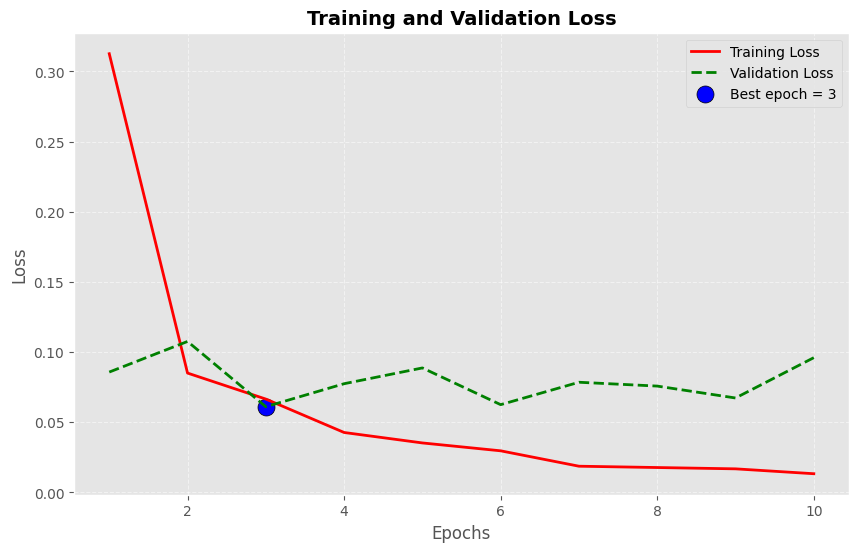

2


In [14]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(Epochs_X, tr_loss_X, color='red', label='Training Loss', linewidth=2)
plt.plot(Epochs_X, val_loss_X, color='green', label='Validation Loss', linestyle='--', linewidth=2)
plt.scatter(index_loss_X + 1, loss_lowest_X, s=150, c='blue', label=f'Best epoch = {index_loss_X + 1}', edgecolors='black')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

print(np.argmin(val_loss_X))

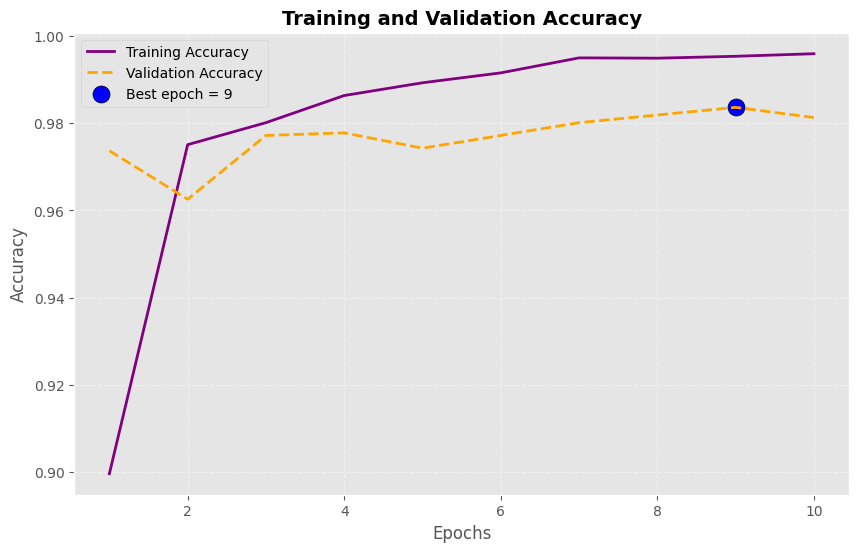

In [15]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(Epochs_X, tr_acc_X, color='purple', label='Training Accuracy', linewidth=2)
plt.plot(Epochs_X, val_acc_X, color='orange', label='Validation Accuracy', linestyle='--', linewidth=2)
plt.scatter(index_acc_X + 1, acc_highest_X, s=150, c='blue', label=f'Best epoch = {index_acc_X + 1}', edgecolors='black')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()